# Opinion Mining: Information Extraction for Product Development
#### Ayan Karim

# Aspect-Based Opinion Mining

After creating our labels using topic modeling, we can move on to extract aspect-based sentiments about from our text. The pipeline here will consist of:

1. Importing and Cleaning our Data
2. Importing our Opinions Lexicon and pre-trained models (Word2Vec, Multi-Label Powerset, SVM Classifier, LDA)
3. Use LDA model to assign topic labels to our text corpus
4. Using Spacy Dependency parser to extract aspects, sentiments and scoring them based on our Opinions Lexicon
5. Using a combination of Word2Vec and SVM to assign aspects to topics
6. Visualize and compare our Products and their sentiments


In [1]:
# Import Dependencies and modules
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from string import punctuation
from collections import Counter
from io import StringIO
from nltk.corpus import stopwords
import nltk
import glob
import errno
import os
import json
import pickle
import en_core_web_md
from spacy import displacy
import gensim
from itertools import chain
from gensim import models, corpora, similarities
from gensim.models import CoherenceModel, TfidfModel
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from spacy.lang.en import English
import math
import six

from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from skmultilearn.problem_transform import LabelPowerset

# Description of Data

Although we used a corpus of 12 different phones for our topic modeling, we will only be comparing the iPhone X to the Samsung Galaxy S9, from the perspective of the iPhone, so we're only going to be working with their text documents. This gives us a total of 90 text documents of varying size to work with. Like in the topic model, we collected data from search queries in digitaltrends.com, gizmodo.com, techradar.com.


# Load Data

In [2]:
# Load each json file
with open('iphonex_digtrends.json') as f:
    iphonex_digtrends = json.load(f)

with open('iphonex_gizmodo.json') as f:
    iphonex_gizmodo = json.load(f)

with open('iphonex_techradar.json') as f:
    iphonex_techradar = json.load(f)

with open('S9_digtrends.json') as f:
    S9_digtrends = json.load(f)

with open('S9_gizmodo.json') as f:
    S9_gizmodo = json.load(f)

with open('S9_techradar.json') as f:
    S9_techradar = json.load(f)

# Clean Data

In [3]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!

    text = str(text).replace("\n", "")
    text = str(text).replace("\t", "")
    text = str(text).replace("\\n", "")
    text = str(text).replace("\\t", "")
    text = str(text).replace("\\", "")
    text = str(text).replace("xa0", " ")
    text = str(text).replace("\'", "")
    text = re.sub("<p>", "", str(text))
    text = re.sub("</p>", "", str(text))
    text = re.sub("</a>", "", str(text))
    text = re.sub('<[^>]+>', "", str(text))
    text = str(text).replace("\\u2019", "")
    text = str(text).replace("\\u2013", "")
    text = str(text).replace("\\u2018", "")
    text = str(text).replace("\\u00a0", "")
    text = str(text).replace("\\u00a3", "")
    text = str(text).replace("\u2014", "")
    text = str(text).replace("\u201d", "")
    text = str(text).replace("\u201c", "")
    return text


In [4]:
# Populate each JSON file into a data frame

iphonex_digtrends = pd.DataFrame.from_dict(iphonex_digtrends, orient='columns')
iphonex_gizmodo = pd.DataFrame.from_dict(iphonex_gizmodo, orient='columns')
iphonex_techradar = pd.DataFrame.from_dict(iphonex_techradar, orient='columns')
S9_digtrends = pd.DataFrame.from_dict(S9_digtrends, orient='columns')
S9_gizmodo = pd.DataFrame.from_dict(S9_gizmodo, orient='columns')
S9_techradar = pd.DataFrame.from_dict(S9_techradar, orient='columns')

In [5]:
# Define function to clean text
def clean_text(df):
    # Convert lists to strings and remove brackets
    df['text'] = df['text'].astype(str)
    df['author'] = df['author'].astype(str)

    df['text'] = df['text'].map(lambda x: x.strip('[]'))
    df['author'] = df['author'].map(lambda x: x.strip('[]'))

    # Clean text
    df['text'] = df['text'].apply(lambda x: text_cleaner(x))
    df['title'] = df['title'].apply(lambda x: text_cleaner(x))
    df['author'] = df['author'].apply(lambda x: text_cleaner(x))


In [6]:
# Put dataframes into a list to iterate through
dataframes = [iphonex_digtrends, iphonex_gizmodo, iphonex_techradar, S9_digtrends, S9_gizmodo, S9_techradar]

# Clean each Data Frame
for dataframe in dataframes:
    clean_text(dataframe)

# Label all the rows in the dataframe with the type of phone discussed in text

iphones = [iphonex_digtrends, iphonex_gizmodo, iphonex_techradar]
s9s = [S9_digtrends, S9_gizmodo, S9_techradar]

for dataframe in iphones:
    dataframe['phone'] = 'IPhone X'
    
for dataframe in s9s:
    dataframe['phone'] = 'Samsung Galaxy S9'
    
    
# Concat all the dataframes into one dataframe
all_frames = [iphonex_digtrends, iphonex_gizmodo, iphonex_techradar, S9_digtrends, S9_gizmodo, S9_techradar]
df = pd.concat(all_frames)


In [7]:
# Visualize dataframe
df.head()

,author,text,title,phone
0,Eric Brackett,The iPhone X launched to stellar reviews and e...,Shrinking demand forces Apple to slow down iPh...,IPhone X
1,Lucas Coll,"When it comes to high-quality devices, like th...",Looking to upgrade? These are the best iPhone ...,IPhone X
2,Simon Hill,The iPhone X is completely different from any ...,"The most common iPhone X problems, and how to ...",IPhone X
3,Trevor Mogg,"If you’re in the market for an iPhone X, and p...","This $4,600 solar charger comes with an iPhone...",IPhone X
4,Mark Jansen,", The initial estimates, set during the Novemb...",Apple will halve iPhone X production after lim...,IPhone X


# Load all Pre-Trained Models

In [8]:
# Load Opinion Lexicon
negatives = open('negative-words.txt', encoding = 'latin-1')
positives = open('positive-words.txt', encoding = 'latin-1')

# Read file
neg_unedit = [line.strip() for line in negatives.readlines()]
pos_unedit = [line.strip() for line in positives.readlines()]

# Extract only the list of words in the lexicon
neg = neg_unedit[31:]
pos = pos_unedit[30:]

# Compile opinion words
opinion_words = neg + pos

In [9]:
opinion_words[:10]

['2-faced',
 '2-faces',
 'abnormal',
 'abolish',
 'abominable',
 'abominably',
 'abominate',
 'abomination',
 'abort',
 'aborted']

In [10]:
# Load Google's pre-trained Word2Vec model.
word2vec = gensim.models.KeyedVectors.load_word2vec_format('/Users/ayankarim/Desktop/GoogleNews-vectors-negative/GoogleNews-vectors-negative300.bin', binary=True) 

# load the Topic Model from previous notebook
lda = pickle.load(open("lda_model.pkl", 'rb'))

# load the Multi-label binarizer from previous notebook
mlb = pickle.load(open("mlb.pkl", 'rb'))

# load the fitted naive bayes model from previous notebook
svm_model = pickle.load(open("svm_model.pkl", 'rb'))


# Word2Vec Pre-trained on Google News Dataset

In [11]:
def check_similarity(aspects, word):
    similarity = []
    for aspect in aspects:
        similarity.append(word2vec.n_similarity([aspect], [word]))
    # set threshold for max value
    if max(similarity) > 0.05:
        return aspects[np.argmax(similarity)]
    else:
        return None

### Evaluation of Word2Vec: Spearman's Rank-Order Correlation

In [12]:
# topics = ['design', 'function', 'reliability']
# word = 'durable'

# check_similarity(topics, word)

# word embedding from word2vec will be used to supplement the naive bayes categorization
# of aspect terms. 
# word2vec.n_similarity(['reliability'], ["protection"])

In [13]:
# Load word pairs ranked by humans for similarity
wordpairs = pd.read_csv('wordsim353/combined.csv')
wordpairs = wordpairs.sort_values(by='Human (mean)', ascending=False)
wordpairs = wordpairs.reset_index()
wordpairs = wordpairs.drop(['index'], axis=1)

# Populate a second DataFrame of word pairs to assign cosine similarities found from Word2Vec
wordpairs_evaluates = pd.DataFrame()
wordpairs_evaluates['Word 1'] = []
wordpairs_evaluates['Word 2'] = []
wordpairs_evaluates['Similarity'] = []

word1 = []
word2 = []

wordpairs['Word 1'].apply(lambda x: word1.append(x))
wordpairs['Word 2'].apply(lambda x: word2.append(x))

word1_evaluate = []
word2_evaluate = []
similarity = []
i = 0

for i in range(353):
    word1_evaluate.append(word1[i])
    word2_evaluate.append(word2[i])
    x = word2vec.n_similarity([word1[i]], [word2[i]])
    similarity.append(x) 
    
wordpairs_evaluates['Word 1'] = word1_evaluate
wordpairs_evaluates['Word 2'] = word2_evaluate
wordpairs_evaluates['Similarity'] = similarity


wordpairs = wordpairs[(wordpairs['Word 1'] != 'fuck')&(wordpairs['Word 1'] != 'shit')]
wordpairs_evaluates = wordpairs_evaluates[(wordpairs_evaluates['Word 1'] != 'fuck')&(wordpairs_evaluates['Word 1'] != 'shit')]

In [14]:
wordpairs.head()

,Word 1,Word 2,Human (mean)
0,tiger,tiger,10.00
2,journey,voyage,9.29
3,midday,noon,9.29
4,dollar,buck,9.22
5,money,cash,9.15


In [15]:
wordpairs_evaluates.head()

,Word 1,Word 2,Similarity
0,tiger,tiger,1.000000
2,journey,voyage,0.683085
3,midday,noon,0.552741
4,dollar,buck,0.256212
5,money,cash,0.615122


In [16]:
from scipy.stats import spearmanr

# Caluculate Spearman Correlation and p_value to determine significance
human_scores = wordpairs['Human (mean)'].tolist()
word2vec_scores = wordpairs_evaluates['Similarity'].tolist()

corr, p_value = spearmanr(human_scores, word2vec_scores)

print("Spearman's Correlation: " + str(corr))
print("P-Value: " + str(p_value))

Spearman's Correlation: 0.7042308822748308
P-Value: 5.1862753174522567e-54


### Evaluating Word2Vec Model

My methodology for evaluating our word2vec model was to download a dataset from The WordSimilarity-353 Test Collection, which includes ordered word-pairs that were paired for similarity and ranked by humans. I copied that dataset and applied my Word2Vec model to it and sorted it from most similar to least. Then I compared how well my model did in relation to WordSim353 using Spearman's Correlation.

Our model did quite well, scoring at 0.704, so our model finds similarities comparable to humans 70% of the time, with a probability of 5.1862753174522567e-54 that this occurred due to chance.


# Aspect-Based Sentiment Analysis

In [17]:
# Load Neural Coreference to replace parse text and replace pronouns
nlp = en_core_web_md.load()

# Define Stop Words and extend it with some custom words
stop_words = stopwords.words('english')
stop_words.extend(['pixel', 'iphone', 'samsung', 'apple', 'essential', 'xs', 'max', 
                  'huawei', 'galaxy', 'note', 'moto', 'oneplus', 'android', 'mate', 'pro', 'lg', 'sony', 'razer', 'phone', 'company', 
                  'smartphone', 'google', 'thinq', 'nokia', 'htc', 'xperia', 'xz', 'mo', 'issues', 'issue', 'problem', 'concerns', 'way', 'works', 'likes', 's9', 'right', 'xr'])

In [18]:
def assign_term_to_aspect(aspect_sent, terms_dict, sent_dict, pred): # [5]
    '''
    function: takes in a sentiment dictionary and appends the aspect dictionary
    inputs: sent_dict is a Counter in the form Counter(term:sentiment value)
            aspect_sent is total sentiment tally
            terms_dict is dict with individual aspect words associated with sentiment
    output: return two types of aspect dictionaries: 
            updated terms_dict and aspect_sent
    '''
    
    aspects = ['design', 'function', 'reliability']
    
    # Check word2vec
    for term in sent_dict:
        try:
            # The conditions for when to use the NB classifier as default vs word2vec
            if check_similarity(aspects, term):
                terms_dict[check_similarity(aspects, term)][term] += sent_dict[term]
                if sent_dict[term] > 0:
                    aspect_sent[check_similarity(aspects, term)]["pos"] += sent_dict[term]
                else:
                    aspect_sent[check_similarity(aspects, term)]["neg"] += abs(sent_dict[term])
            elif (pred[0] == "anecdotes/miscellaneous"):
                continue
            elif (len(pred)==1):
                terms_dict[pred[0][term]] += sent_dict[term]
                if sent_dict[term] > 0:
                    aspec_sent[pred[0]]['pos'] += sent_dict[term]
                else:
                    aspect_sent[pred[0]]['neg'] += abs(sent_dict[term])
            # if unable to classify via SVM or word2vec, then put them in misc. bucket
            else:
                terms_dict['misc'][term] += sent_dict[term]
                if sent_dict[term] > 0:
                    aspect_sent['misc']['pos'] += sent_dict[term]
                else:
                    aspect_sent['misc']['neg'] += abs(sent_dict[term])
                    
        except:
            print(term, "not in vocab")
            continue
    return aspect_sent, terms_dict

# Define feature_sentiment function
def feature_sentiment(sentence): # [5]
    '''
    input: dictionary and sentence
    function: appends dictionary with new features if the feature did not exist previously,
              then updates sentiment to each of the new or existing features
    output: updated dictionary
    '''
    
    sent_dict = Counter()
    sentence = nlp(sentence)
    debug = 0
    for token in sentence:
    #    print(token.text,token.dep_, token.head, token.head.dep_)
        # check if the word is an opinion word, then assign sentiment
        if token.text in opinion_words:
            sentiment = 1 if token.text in pos else -1
            # if target is an adverb modifier (i.e. pretty, highly, etc.)
            # but happens to be an opinion word, ignore and pass
            if (token.dep_ == "advmod"):
                continue
            elif (token.dep_ == "amod"):
                sent_dict[token.head.text] += sentiment
            # for opinion words that are adjectives, adverbs, verbs...
            else:
                for child in token.children:
                    # if there's a adj modifier (i.e. very, pretty, etc.) add more weight to sentiment
                    # This could be better updated for modifiers that either positively or negatively emphasize
                    if ((child.dep_ == "amod") or (child.dep_ == "advmod")) and (child.text in opinion_words):
                        sentiment *= 1.5
                    # check for negation words and flip the sign of sentiment
                    if child.dep_ == "neg":
                        sentiment *= -1
                for child in token.children:
                    # if verb, check if there's a direct object
                    if (token.pos_ == "VERB") & (child.dep_ == "dobj"):                        
                        sent_dict[child.text] += sentiment
                        # check for conjugates (a AND b), then add both to dictionary
                        subchildren = []
                        conj = 0
                        for subchild in child.children:
                            if subchild.text == "and":
                                conj=1
                            if (conj == 1) and (subchild.text != "and"):
                                subchildren.append(subchild.text)
                                conj = 0
                        for subchild in subchildren:
                            sent_dict[subchild] += sentiment

                # check for negation
                for child in token.head.children:
                    noun = ""
                    if ((child.dep_ == "amod") or (child.dep_ == "advmod")) and (child.text in opinion_words):
                        sentiment *= 1.5
                    # check for negation words and flip the sign of sentiment
                    if (child.dep_ == "neg"): 
                        sentiment *= -1
                
                # check for nouns
                for child in token.head.children:
                    noun = ""
                    if (child.pos_ == "NOUN") and (child.text not in sent_dict):
                        noun = child.text
                        # Check for compound nouns
                        for subchild in child.children:
                            if subchild.dep_ == "compound":
                                noun = subchild.text + " " + noun
                        sent_dict[noun] += sentiment
                    debug += 1
    return sent_dict

def classify_and_sent(sentence, aspect_sent, terms_dict): # [5]
    '''
    function: classify the sentence into a category, and assign sentiment
    note: aspect_dict is a parent dictionary with all the aspects
    input: sentence & aspect dictionary, which is going to be updated
    output: updated aspect dictionary
    '''
    # classify sentence with NB classifier
    predicted = svm_model.predict([sentence])
    pred = mlb.inverse_transform(predicted)
    
    # get aspect names and their sentiment in a dictionary form
    sent_dict = feature_sentiment(sentence)
    
    for key in list(sent_dict):
        if key in stop_words:
            del sent_dict[key]
    
    # try to categorize the aspect names into the 4 aspects in aspect_dict
    aspect_sent, terms_dict = assign_term_to_aspect(aspect_sent, terms_dict, sent_dict, pred[0])
    return aspect_sent, terms_dict

def split_sentence(text): # [5]
    '''
    splits review into a list of sentences using spacy's sentence parser
    '''
    review = nlp(text)
    bag_sentence = []
    start = 0
    for token in review:
        if token.sent_start:
            bag_sentence.append(review[start:(token.i-1)])
            start = token.i
        if token.i == len(review)-1:
            bag_sentence.append(review[start:(token.i+1)])
    return bag_sentence

# Remove special characters using regex
def remove_special_char(sentence): # [5]
    return re.sub(r"[^a-zA-Z0-9.',:;?]+", ' ', sentence)

# Create function to run pipeline that extracts aspects from sentiments and assigns them to topics
def review_pipe(review, aspect_sent, terms_dict={'design':Counter(), 'function':Counter(), 'reliability':Counter()}): # [5]
    sentences = split_sentence(review)
    for sentence in sentences:
        sentence = remove_special_char(str(sentence))
        aspect_sent, terms_dict = classify_and_sent(sentence.lower(), aspect_sent, terms_dict)
    return aspect_sent, terms_dict


In [19]:
# Create Dataframes for both phone
iphonex_df = df[df['phone']=='IPhone X']
s9_df = df[df['phone'] =='Samsung Galaxy S9']

# Make list of text documents for both phones
iphonex_text = []
iphonex_text.append(list(iphonex_df.text))

s9_text = []
s9_text.append(list(s9_df.text))

In [20]:
# Apply functions for Aspect-Based Semantic Analysis on iPhone X
terms_dict={'design':Counter(), 'function':Counter(), 'reliability':Counter()}
aspect_sent={'design':Counter(), 'function':Counter(), 'reliability':Counter()}

for item in iphonex_text:
    for sentences in item:
        iphonex_sent, iphonex_terms = review_pipe(sentences, aspect_sent, terms_dict)

tsmc not in vocab
disappointment not in vocab
deals not in vocab
texts not in vocab
record breaking not in vocab
apple iphone not in vocab
6s discounts not in vocab
edge gadgets not in vocab
sticker shock not in vocab
charging capability not in vocab
don t not in vocab
face not in vocab
reports not in vocab
static image not in vocab
software issue not in vocab
accessory maker not in vocab
spelling error not in vocab
production run not in vocab
share prices not in vocab
loss not in vocab
apple hardware not in vocab
deals not in vocab
face not in vocab
battery life not in vocab
zerolemon not in vocab
don t not in vocab
chin not in vocab
6,000mah not in vocab
smile not in vocab
battery case not in vocab
dirt not in vocab
water resistance not in vocab
audiomod not in vocab
audiomod not in vocab
phone vibrating not in vocab
morning greeting not in vocab
time limits not in vocab
app limits not in vocab
app limits not in vocab
app limits not in vocab
app limits not in vocab
app limits not in 

In [21]:
# Apply functions for Aspect-Based Semantic Analysis on Samsung S9
terms_dict={'design':Counter(), 'function':Counter(), 'reliability':Counter()}
aspect_sent={'design':Counter(), 'function':Counter(), 'reliability':Counter()}

for item in s9_text:
    for sentences in item:
        s9_sent, s9_terms = review_pipe(sentences, aspect_sent, terms_dict)

shots not in vocab
blog not in vocab
bet not in vocab
trade not in vocab
360 not in vocab
graphics driver not in vocab
s9 galaxy models not in vocab
freeze not in vocab
capture technology not in vocab
loom.ai not in vocab
shape technology not in vocab
anger not in vocab
galaxy s9 not in vocab
product strategy not in vocab
galaxy s9 not in vocab
service providers not in vocab
noses not in vocab
lighting conditions not in vocab
forehead not in vocab
bixby not in vocab
trade not in vocab
shots not in vocab
doesn t not in vocab
galaxy s9 not in vocab
operating system not in vocab
home support not in vocab
galaxy owners not in vocab
repair option not in vocab
galaxy s9 not in vocab
surprise not in vocab
phone division not in vocab
seung analyst woo not in vocab
slump not in vocab
1,425 not in vocab
1,600 not in vocab
g phone not in vocab
s10 not in vocab
smartphone day fanatic not in vocab
s10 models not in vocab
year not in vocab
spot not in vocab
haven t not in vocab
didn t not in vocab
a

### Observation

If we look at the words that aren't in vocab from the output above, we see that there are many useful words that aren't being considered within our analysis such as "freeze" or "lighting conditions". To improve the model, I should really consider how to include all these words in the analysis. One way may be to create bigrams, which may make it easier to analyze words like "lighting conditions" or "capture technology".

In [22]:
# final output aspect sentiment, which is the overall sentiment scores
iphonex_sent

{'design': Counter({'pos': 308.0, 'neg': 134.5}),
 'function': Counter({'pos': 225.5, 'neg': 130.5}),
 'reliability': Counter({'neg': 121.5, 'pos': 243.0})}

In [23]:
iphonex_terms

{'design': Counter({'reviews': 2,
          'sales': -2,
          'guidance': 2,
          'ams': -1,
          'aesthetics': 1,
          'tech': 4,
          'penny': 1,
          'frame': 1,
          'gold': 9.5,
          'colors': 3,
          'piece': 1,
          'specs': 0,
          'software': 3,
          'camera': 9.0,
          'color': 3,
          'finish': 1,
          'fall': -2,
          'luxury': 3,
          'edge': 4,
          'headphones': 1.5,
          'plans': 2,
          'image': 1,
          'outline': -1,
          'manufacturer': -1,
          'offering': 1,
          'elements': 1,
          'charger': 3,
          'models': 3,
          'ground': -1,
          'brand': -1,
          'displays': -1,
          'dollar': 2,
          'one': 2,
          'flagships': -1,
          'hardware': 0,
          'flagship': 1,
          'display': 5.5,
          'features': 3,
          'series': 0,
          'choice': 3,
          'design': 11,
          'bump

In [24]:
s9_sent

{'design': Counter({'pos': 288.5, 'neg': 108}),
 'function': Counter({'neg': 106, 'pos': 235.0}),
 'reliability': Counter({'neg': 77.5, 'pos': 195.25})}

In [25]:
s9_terms

{'design': Counter({'features': 15.5,
          'feature': 5,
          'details': 3,
          'plan': 2,
          'one': 5,
          'offers': -1,
          'shader': -3,
          'browser': -3,
          'video': -6,
          'bug': -1,
          'fix': 1,
          'variety': 2,
          'characters': 0,
          'hardware': 1.5,
          'photograph': 1,
          'technology': 2,
          'aspirations': 1,
          'algorithms': 1,
          'winner': 5.5,
          'accessories': 1,
          'excitement': 2,
          'place': 1,
          'lighting': 2,
          'specs': 2,
          'ground': 1,
          'camera': 8.5,
          'choice': 3,
          'design': 5,
          'sensor': 1,
          'lot': 2,
          'tie': 1,
          'set': 1,
          'reviews': 2,
          'experience': 3,
          'display': 9,
          'folks': 1,
          'owners': 1,
          'promises': 1,
          'locations': 1,
          'qualcomm': 2,
          'chintzy': -1,
  

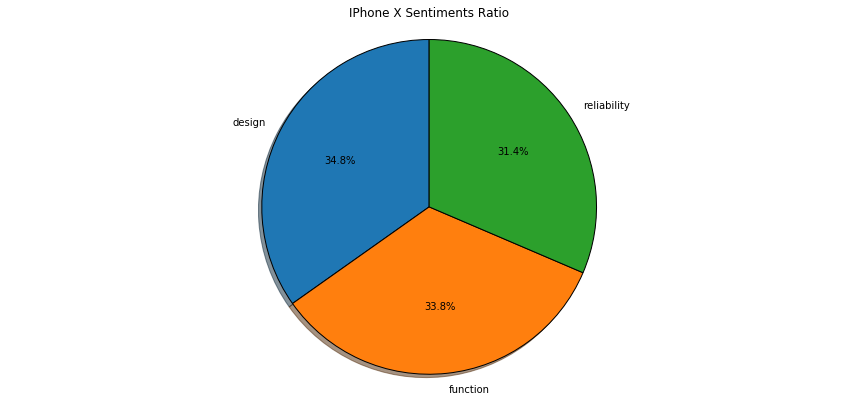

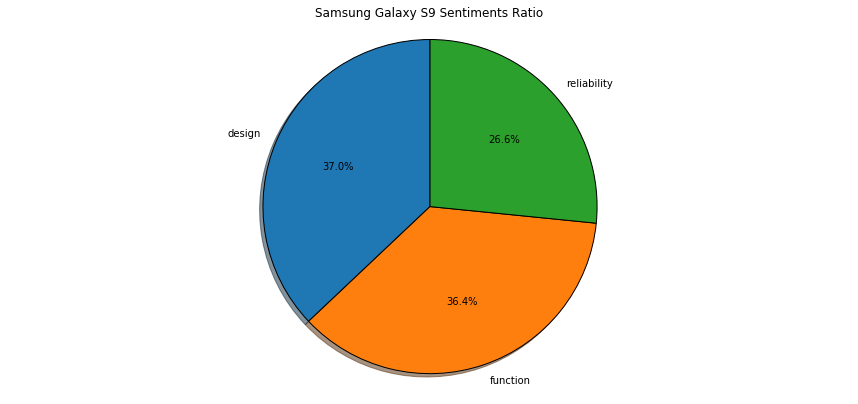

In [26]:
iphonex_sent_df = pd.DataFrame(iphonex_sent)
iphonex_neg_df = iphonex_sent_df.filter(like="neg", axis=0)
iphonex_design = iphonex_neg_df['design'].sum()
iphonex_function = iphonex_neg_df['function'].sum()
iphonex_reliability = iphonex_neg_df['reliability'].sum()
iphonex_ratio = [iphonex_design, iphonex_function, iphonex_reliability]
iphonex_labels = 'design', 'function', 'reliability'


s9_sent_df = pd.DataFrame(s9_sent)
s9_neg_df = s9_sent_df.filter(like="neg", axis=0)
s9_design = s9_neg_df['design'].sum()
s9_function = s9_neg_df['function'].sum()
s9_reliability = s9_neg_df['reliability'].sum()
s9_ratio = [s9_design, s9_function, s9_reliability]
s9_labels = 'design', 'function', 'reliability'

plt.figure(figsize=(15,15))
ax1 = plt.subplot(211)
pie_wedge_collection1 = ax1.pie(iphonex_ratio, labels=iphonex_labels, autopct='%1.1f%%', shadow=True, startangle=90)
for pie_wedge in pie_wedge_collection1[0]:
    pie_wedge.set_edgecolor('k')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("IPhone X Sentiments Ratio")
plt.show()

plt.figure(figsize=(15,15))
ax2 = plt.subplot(212)
pie_wedge_collection2 = ax2.pie(s9_ratio, labels=s9_labels, autopct='%1.1f%%', shadow=True, startangle=90)
for pie_wedge in pie_wedge_collection2[0]:
    pie_wedge.set_edgecolor('k')
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Samsung Galaxy S9 Sentiments Ratio")
plt.show()

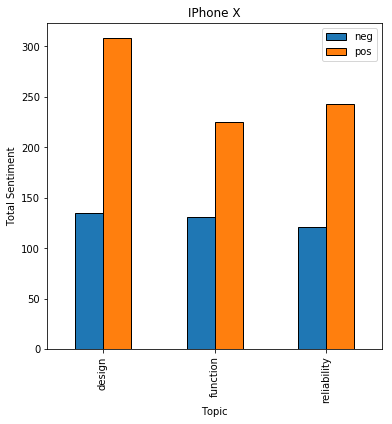

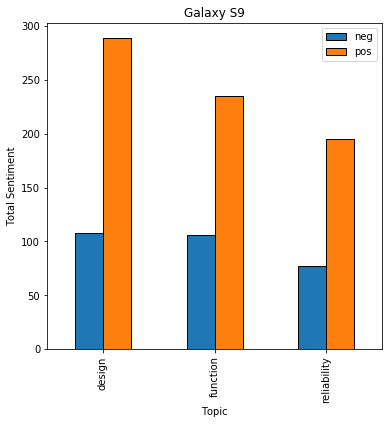

In [27]:
# quick visualization
pd.DataFrame(iphonex_sent).T.plot(kind='bar', edgecolor='k', figsize=(6,6))
plt.xlabel('Topic')
plt.ylabel('Total Sentiment')
plt.title('IPhone X')
plt.show()

# quick visualization
pd.DataFrame(s9_sent).T.plot(kind='bar', edgecolor='k', figsize=(6,6))
plt.xlabel('Topic')
plt.ylabel('Total Sentiment')
plt.title('Galaxy S9')
plt.show()

In [28]:
from collections import defaultdict

# Create separate dataframes sorting positive sentiments and negative sentaments
lowest = defaultdict()
highest = defaultdict()
for i in iphonex_terms:
    if iphonex_terms[i]:
        highest[i] = iphonex_terms[i].most_common()[:20]
        lowest[i] = iphonex_terms[i].most_common()[-10:]
        
iphonex_highest_df = pd.DataFrame(highest)
iphonex_lowest_df = pd.DataFrame(lowest)

iphonex_highest_df.head()

,design,function,reliability
0,"(design, 11)","(apps, 6.5)","(protection, 16)"
1,"(gold, 9.5)","(case, 6)","(top, 16)"
2,"(camera, 9.0)","(option, 5)","(performance, 8)"
3,"(improvement, 8)","(life, 5)","(improvements, 8)"
4,"(work, 6)","(gb, 4)","(quality, 6)"


In [29]:
# Create separate dataframes sorting positive sentiments and negative sentaments
lowest = defaultdict()
highest = defaultdict()
for i in s9_terms:
    if s9_terms[i]:
        highest[i] = s9_terms[i].most_common()[:20]
        lowest[i] = s9_terms[i].most_common()[-10:]
        
s9_highest_df = pd.DataFrame(highest)
s9_lowest_df = pd.DataFrame(lowest)

s9_highest_df.head()

,design,function,reliability
0,"(features, 15.5)","(phones, 12)","(top, 16)"
1,"(photos, 12)","(scan, 12)","(advantage, 5.5)"
2,"(display, 9)","(screen, 9)","(improvements, 5.5)"
3,"(camera, 8.5)","(fun, 6)","(billion, 5)"
4,"(colors, 8)","(part, 5)","(handsets, 5)"


In [30]:
# Render plot that makes the visualization of tables a bit more aesthetic
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='k',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs): # [5]
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0,1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
        
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)
    
    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors)])
    return ax

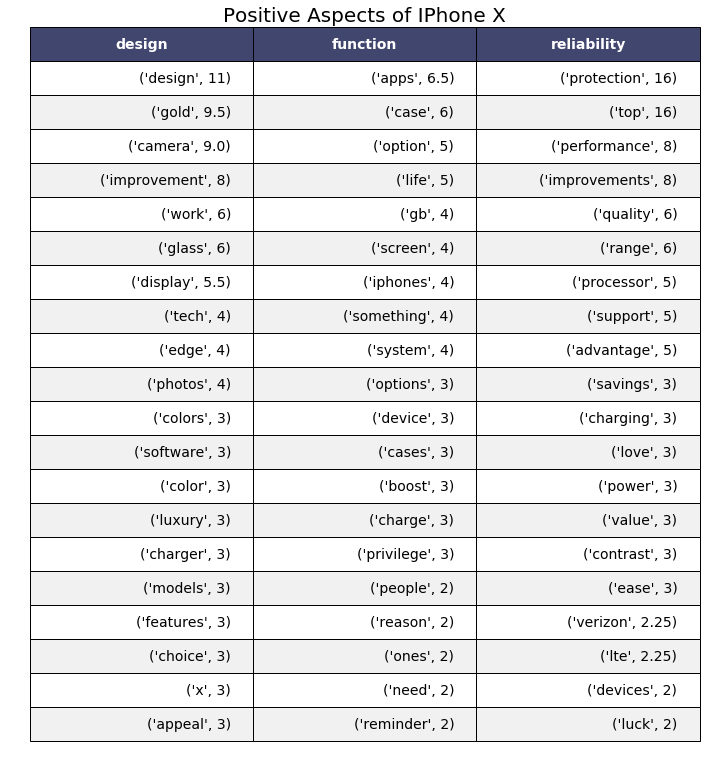

In [31]:
# Render Positive Aspects of IPhone X
render_mpl_table(iphonex_highest_df, header_columns=0, col_width=4.0)
plt.title('Positive Aspects of IPhone X', fontdict={'fontsize':20})
plt.show()

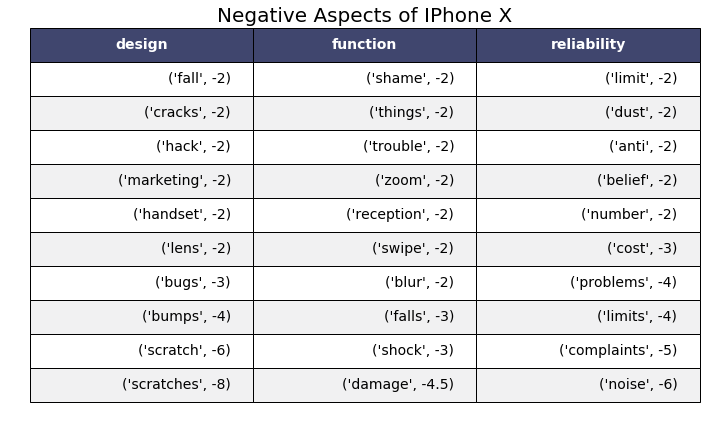

In [32]:
# Render Negative Aspects of IPhone X
render_mpl_table(iphonex_lowest_df, header_columns=0, col_width=4.0)
plt.title('Negative Aspects of IPhone X', fontdict={'fontsize':20})
plt.show()

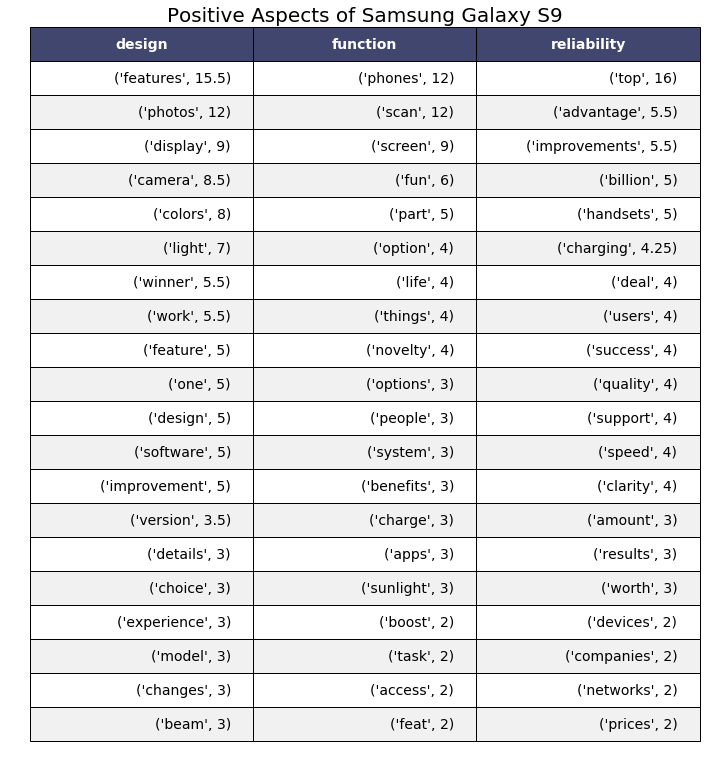

In [33]:
# Render Positive Aspects of Samsung Galaxay S9
render_mpl_table(s9_highest_df, header_columns=0, col_width=4.0)
plt.title('Positive Aspects of Samsung Galaxy S9', fontdict={'fontsize':20})
plt.show()

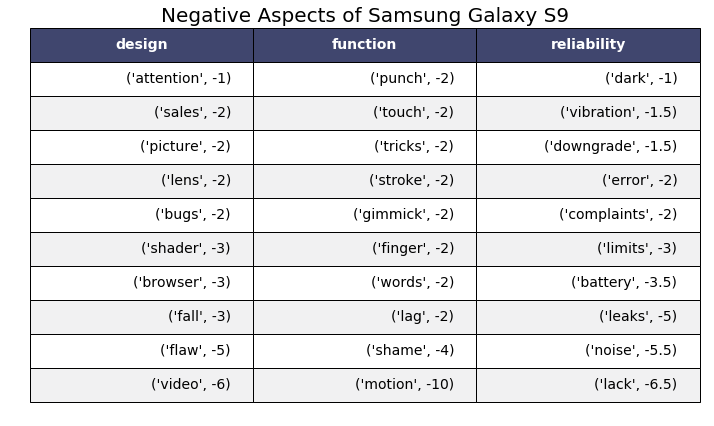

In [34]:
# Render Negative Aspects of Samsung Galaxay S9
render_mpl_table(s9_lowest_df, header_columns=0, col_width=4.0)
plt.title('Negative Aspects of Samsung Galaxy S9', fontdict={'fontsize':20})
plt.show()

### Analyzing Results

So now we have a clean representation of sorted aspects of our phones and their sentiments, grouped into topics and represented in a table. Looking at this table, we can gain a lot of information about our product and that of our competition for the sake of product development.

For example, from viewing the negative aspects of iPhone X, we see that one of the biggest problems with the phone is how easily it breaks. We see that "scratch", "scratches", "bumps", "damage", "shock", "falls" and "cracks" are shown as the most negative aspects of design and function, almost in sequence. So clearly iPhone X has a problem with its durability. Other problems, such as "cost" is also shown.

However, from viewing the negative aspects of Samsung S9, we see that they have a more diverse set of problems from "video", "lag" to "motion" and "battery". So it may be encouraging for iPhone X that at least it's problems are consistent and can be focused, where as that of the Galaxy S9 seem to range a bit.

In [35]:
# Create DataFrame directly comparing iPhone X to Samsung Galaxy S9
df_iphonex = pd.DataFrame(iphonex_sent).T
df_s9 = pd.DataFrame(s9_sent).T

df_iphonex["total"] = df_iphonex.neg + df_iphonex.pos
df_iphonex["neg_norm"] = df_iphonex.neg/(df_iphonex.neg + df_iphonex.pos)
df_iphonex["pos_norm"] = df_iphonex.pos/(df_iphonex.neg + df_iphonex.pos)
df_iphonex["pos/neg"] = (df_iphonex.pos/df_iphonex.neg)

df_s9["total"] = df_s9.neg + df_s9.pos
df_s9["neg_norm"] = df_s9.neg/(df_s9.neg + df_s9.pos)
df_s9["pos_norm"] = df_s9.pos/(df_s9.neg + df_s9.pos)
df_s9["pos/neg"] = (df_s9.pos/df_s9.neg)

# Concate DataFrames of iPhoneX and Galaxy S9 into one DF for comparison's sake
all_phones = pd.DataFrame(df_iphonex.T.design)

IphoneX_design = list(df_iphonex.T.design)
IphoneX_function = list(df_iphonex.T.function)
IphoneX_reliability = list(df_iphonex.T.reliability)
S9_design = list(df_s9.T.design)
S9_function = list(df_s9.T.design)
S9_reliability = list(df_s9.T.design)

all_phones = all_phones.rename(index=str, columns={"design": "IPhoneX design"}) 
all_phones['IPhoneX function'] = IphoneX_function
all_phones['IPhoneX reliability'] = IphoneX_reliability
all_phones['S9 design'] = S9_design
all_phones['S9 function'] = S9_function
all_phones['S9 reliability'] = S9_reliability


# Calculate ratios for all sentiments from the perspective of iPhone X to Samsung Galaxy S9
X_neg_sum = (all_phones['IPhoneX design'].iloc[0] + all_phones['IPhoneX function'].iloc[0] 
             + all_phones['IPhoneX reliability'].iloc[0])
S9_neg_sum = (all_phones['S9 design'].iloc[0] + all_phones['S9 function'].iloc[0] 
             + all_phones['S9 reliability'].iloc[0])
neg_ratio = (X_neg_sum/S9_neg_sum)

X_pos_sum = (all_phones['IPhoneX design'].iloc[1] + all_phones['IPhoneX function'].iloc[1] 
             + all_phones['IPhoneX reliability'].iloc[1])
S9_pos_sum = (all_phones['S9 design'].iloc[1] + all_phones['S9 function'].iloc[1] 
             + all_phones['S9 reliability'].iloc[1])
pos_ratio = (X_pos_sum/S9_pos_sum)

X_total_sum = (all_phones['IPhoneX design'].iloc[2] + all_phones['IPhoneX function'].iloc[2] 
             + all_phones['IPhoneX reliability'].iloc[2])
S9_total_sum = (all_phones['S9 design'].iloc[2] + all_phones['S9 function'].iloc[2] 
             + all_phones['S9 reliability'].iloc[2])
total_ratio = (X_total_sum/S9_total_sum)

X_neg_norm_sum = (all_phones['IPhoneX design'].iloc[3] + all_phones['IPhoneX function'].iloc[3] 
             + all_phones['IPhoneX reliability'].iloc[3])
S9_neg_norm_sum = (all_phones['S9 design'].iloc[3] + all_phones['S9 function'].iloc[3] 
             + all_phones['S9 reliability'].iloc[3])
neg_norm_ratio = (X_neg_norm_sum/S9_neg_norm_sum)

X_pos_norm_sum = (all_phones['IPhoneX design'].iloc[4] + all_phones['IPhoneX function'].iloc[4] 
             + all_phones['IPhoneX reliability'].iloc[4])
S9_pos_norm_sum = (all_phones['S9 design'].iloc[4] + all_phones['S9 function'].iloc[4] 
             + all_phones['S9 reliability'].iloc[4])
pos_norm_ratio = (X_pos_norm_sum/S9_pos_norm_sum)

X_pos_neg_sum = (all_phones['IPhoneX design'].iloc[5] + all_phones['IPhoneX function'].iloc[5] 
             + all_phones['IPhoneX reliability'].iloc[5])
S9_pos_neg_sum = (all_phones['S9 design'].iloc[5] + all_phones['S9 function'].iloc[5] 
             + all_phones['S9 reliability'].iloc[5])
pos_neg_ratio = (X_pos_neg_sum/S9_pos_neg_sum)


# Add column for sentiment ratios between phones
total = [neg_ratio, pos_ratio, total_ratio, neg_norm_ratio, pos_norm_ratio, pos_neg_ratio]
all_phones['IPhoneX vs. Samsung S9 (ratio)'] = total



In [36]:
# Visualize Table
all_phones

,IPhoneX design,IPhoneX function,IPhoneX reliability,S9 design,S9 function,S9 reliability,IPhoneX vs. Samsung S9 (ratio)
neg,134.500000,130.500000,121.500000,108.000000,108.000000,108.000000,1.192901
pos,308.000000,225.500000,243.000000,288.500000,288.500000,288.500000,0.897169
total,442.500000,356.000000,364.500000,396.500000,396.500000,396.500000,0.977722
neg_norm,0.303955,0.366573,0.333333,0.272383,0.272383,0.272383,1.228491
pos_norm,0.696045,0.633427,0.666667,0.727617,0.727617,0.727617,0.914465
pos/neg,2.289963,1.727969,2.000000,2.671296,2.671296,2.671296,0.750938


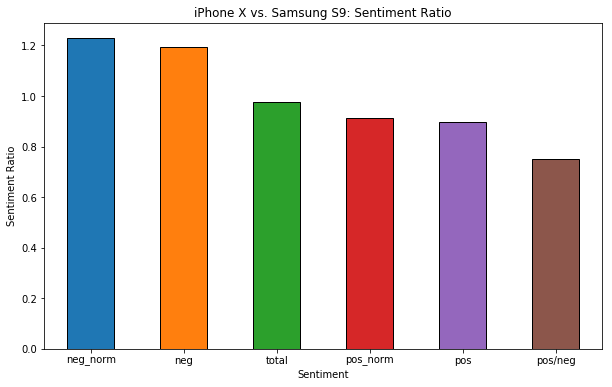

In [37]:
# quick visualization
# pd.DataFrame(all_phones).plot(kind='bar', edgecolor='k', figsize=(6,6))
all_phones['IPhoneX vs. Samsung S9 (ratio)'].sort_values(ascending=False).plot.bar(rot=0, figsize=(10,6), edgecolor='k')
plt.xlabel('Sentiment')
plt.ylabel('Sentiment Ratio')
plt.title('iPhone X vs. Samsung S9: Sentiment Ratio')
plt.show()

### Analyze Comparison Ratios Between Phones

When we look at the ratios of sentiments row by row, we can see some concerning results for iPhone X. There's a higher ratio of negative sentiments for iPhone X (1.193) and a lower ratio of positive sentiments (0.897). The same trend is seen for the ratio of sentiments after normalizing both positive and negative sentiments for the total amount of sentiments (neg_norm: 1.229 and pos_norm: 0.91)

At first, this could be attributed to class imbalance i.e. there may be more opinions about the iPhone X just because it encompasses a larger market. But that isn't the case because a similar number of documents were analyzed for both phones. Furthermore, if class imbalance were responsible, then there would be more positive sentiments for iPhone X as well.

From this table, we can see that our there's a lot of negative opinion about the iPhone compared to that of the S9. iPhone X should consider doing some serious product development in order to change their public opinion.

# References

1. "Apple iPhone sales 2018." Statista. Statista. 19 Feb. 2019 <https://www.statista.com/statistics/263401/global-apple-iphone-sales-since-3rd-quarter-2007/>.

2. Bansal, Shivam, and Natural Language Processing and Machine Learning. "Beginners Guide to Topic Modeling in Python." Analytics Vidhya. 11 Jan. 2019. 19 Feb. 2019 <https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/>.

3. Li, Susan. "Topic Modeling and Latent Dirichlet Allocation (LDA) in Python." Towards Data Science. 31 May 2018. Towards Data Science. 19 Feb. 2019 <https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24>.

4. Li, Susan. "Topic Modelling in Python with NLTK and Gensim – Towards Data Science." Towards Data Science. 30 Mar. 2018. Towards Data Science. 19 Feb. 2019 <https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21>.

5. Min, Peter. "Aspect-Based Opinion Mining (NLP with Python) – Peter Min – Medium." Medium.com. 06 June 2018. Medium. 19 Feb. 2019 <https://medium.com/@pmin91/aspect-based-opinion-mining-nlp-with-python-a53eb4752800>.